In [1]:
'''
  File name: genEngMap.py
  Author: Haoyuan(Steve) Zhang
  Date created: 10/15/2017
'''

'''
  File clarification:
    Compute the energy map of the input image
    - Input I: n x m x 3 or n x m x 2, represents an image. I could be of either color or grayscale.
    - Output e: represents the energy map of n x m matrix.
'''

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import imageio
import time

# convert rgb to grayscale
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


def genEngMap(I):
  dim = I.ndim
  if dim == 3:
    Ig = rgb2gray(I)
  else:
    Ig = I

  Ig = Ig.astype(np.float64())

  [gradx, grady] = np.gradient(Ig)
  e = np.abs(gradx) + np.abs(grady)
  return e

In [2]:
image = Image.open('./image/f6.jpg')
image_array = np.asarray(image)
e = genEngMap(image_array)
print(image_array.shape)

(230, 340, 3)


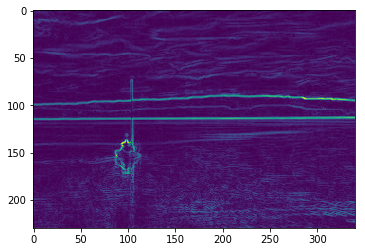

In [3]:
plt.imshow(e)

In [4]:
def cumMinEngVer(e):
    r = e.shape[0]
    c = e.shape[1]
    
    Mx = e.copy()
    Tbx = np.zeros_like(Mx, dtype=np.int)

    for i in range(1, r):
        for j in range(0, c):
            if j == 0:
                idx = np.argmin(Mx[i - 1, j:j + 2])
                Tbx[i, j] = idx + j
                min_energy = Mx[i - 1, idx + j]
            else:
                idx = np.argmin(Mx[i - 1, j - 1:j + 2])
                Tbx[i, j] = idx + j - 1
                min_energy = Mx[i - 1, idx + j - 1]

            Mx[i, j] += min_energy

    return Mx, Tbx

In [5]:
print(np.amax(Tbx))

NameError: name 'Tbx' is not defined

In [6]:
print(Tbx.shape)

NameError: name 'Tbx' is not defined

In [7]:
def cumMinEngHor(e):
    e = e.T
    My, Tby = cumMinEngVer(e)
    My, Tby = My.T, Tby.T
    return My, Tby

In [8]:
def rmHorSeam(I, My, Tby):
    height = My.shape[0]
    width = My.shape[1]
    Iy = np.zeros((height-1,width,3),dtype = np.uint8)
    idx = np.argmin(My[:,width-1])
    Ey = My[idx,width-1]
    for i in reversed(range(0,width)):
        up = I[:int(idx),i:i+1,:]
        down = I[int(idx)+1:,i:i+1,:]
        Iy[:,i:i+1,:] = np.concatenate((up,down),axis=0)
        idx = Tby[int(idx),i]
    return idx

In [9]:
def rmVerSeam(I, Mx, Tbx):
    height = Mx.shape[0]
    width = Mx.shape[1]
    Ix = np.zeros((height,width-1,3),dtype = np.uint8)
    idx = np.argmin(Mx[height-1:])
    Ex = Mx[height-1,idx]
    for i in reversed(range(0,height)):
        left = I[i:i+1,:int(idx),:]
        right = I[i:i+1,int(idx)+1:,:]
        Ix[i:i+1,:,:] = np.concatenate((left,right),axis=1)
        idx = Tbx[i,int(idx)]
    return idx

In [10]:
My, Tby = cumMinEngVer(e)

In [11]:
idx = rmVerSeam(image_array, My, Tby)
print(idx)

0


In [14]:
def carv(I, nr, nc,animation = True):
    
    T = np.zeros((nr+1,nc+1))
    dp = np.empty((nr+1,nc+1),dtype=np.ndarray)
    direction = np.zeros((nr+1,nc+1),dtype = str)
    dp[0,0] = I
    
    for i in range(nr):
        e = genEngMap(dp[i,0])
        My, Tby = cumMinEngHor(e)
        Iy, Ey = rmHorSeam(dp[i,0],My,Tby)
        dp[i+1,0] = Iy
        T[i+1,0] = Ey
        direction[i+1,0] = 'D'
        print('Step {} of {}'.format(i+1,nr))
    
    for i in range(nc):
        e = genEngMap(dp[0,i])
        Mx, Tbx = cumMinEngVer(e)
        Ix, Ex = rmVerSeam(dp[0,i],Mx,Tbx)
        dp[0,i+1] = Ix
        T[0,i+1] = Ex
        direction[0,i+1] = 'R'
        print('Step {} of {}'.format(i+1,nc))
        
    cnt = 0
    for i in range(nr):
        for j in range(nc):
            e_r = genEngMap(dp[i,j+1])
            My, Tby = cumMinEngHor(e_r)
            Iy, Ey = rmHorSeam(dp[i,j+1],My,Tby)
            Cost_r = T[i,j+1] + Ey
            
            e_c = genEngMap(dp[i+1,j])
            Mx, Tbx = cumMinEngVer(e_c)
            Ix, Ex = rmVerSeam(dp[i+1,j],Mx,Tbx)
            Cost_c = T[i+1,j] + Ex
            
            if Cost_c < Cost_r:
                T[i+1,j+1] = Cost_c
                dp[i+1,j+1] = Ix
                direction[i+1,j+1] = 'D'
            else:
                T[i+1,j+1] = Cost_r
                dp[i+1,j+1] = Iy
                direction[i+1,j+1] = 'R'
                
            cnt += 1
            print('Step {} of {}'.format(cnt,nr*nc))
    
    if animation == True:
        print('Generate Gif...')
        frame_list = animate(dp, direction, nr, nc)
        timestr = time.strftime("%Y%m%d-%H%M%S")
        imageio.mimsave('./result_gif/{}.gif'.format(timestr), frame_list)
        print('Process Completed')
        
    Ic = dp[nr,nc]
    return Ic,T

In [15]:
Ic,T = carv(image_array,3,5,True)

TypeError: 'numpy.int64' object is not iterable

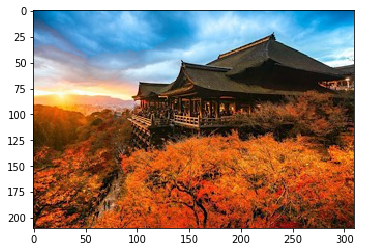

In [209]:
timestr = time.strftime("%Y%m%d-%H%M%S")
plt.imsave('./result_img/{}.jpg'.format(timestr), Ic)
plt.imshow(Ic)

In [149]:
Ic, T, vid = carv_3(image_array,20,20)